# Static contract Type

Static contracts are defined as arrays of intervals. Each interval is associated with a scalar value sent via a wire.

In [1]:
# References: 
# Catlab: https://github.com/AlgebraicJulia/AlgebraicDynamics.jl/blob/master/src/dwd_dynam.jl
# Algebraic Dynamics: https://github.com/AlgebraicJulia/Catlab.jl/blob/master/src/wiring_diagrams/Directed.jl
# Interval sets: https://github.com/JuliaMath/IntervalSets.jl

In [2]:
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
#-------
using IntervalSets  # Library is required to create intervals of real numbers

In [3]:
# Type that accepts all bound conditions, yet has specific type
const NInterval = Vector{ Union{ClosedInterval{T}, 
                        OpenInterval{T}, 
                        Interval{:open, :closed, T}, 
                        Interval{:closed, :open, T} } } where T<:Real

# Contracts are defined via intervals
struct StaticContract{T<:Real}
    ninputs::Int
    noutputs::Int
    input::NInterval{T}
    output::NInterval{T}
    
    # Constructor
    function StaticContract{T}(input::Vector, output::Vector) where T<:Real
        ninputs = length(input)
        noutputs = length(output)
        
        # cannot have empty contract
        for contract in [input; output]
            if isempty(contract)
                error("the interval $contract is backwards")
            end
        end
        
        new{T}(ninputs, noutputs, input, output)
    end
end

In [4]:
function Base.show(io::IO, vf::StaticContract)            
    # Check all contracts
    list = [vf.input; vf.output]
    output = ""
    
    # iterate across all contracts
    len = length(list)
    
    for i in 1:len
        contract = list[i]
        # Switch symbol for infinity
        if -contract.left == contract.right == Inf
            output *= "ℝ"
        else
            left = contract.left == -Inf ? "-∞" : contract.left
            right = contract.right == Inf ? "∞"  : contract.right
            output *= "[$left,$right]"
        end
        # add product operator [spaces make it easier to read]
        if i != len
            output *= " × "
        end
    end  
    
    # display combined string
    print("StaticContract( $output )")
end

In [5]:
function oapply(d::WiringDiagram, ms::Vector{StaticContract{T}}) where T
    # boxes in diagram
    box = boxes(d)     
    
    # Ensure machines fill diagram
    if nboxes(d) != length(ms)
        error("there are $nboxes(d) boxes but $length(ms) machines")
    end
        # each wire must have a contract
    for id in 1:nboxes(d)
        b = box[id]
        if length(b.input_ports) != ms[id].ninputs || length(b.output_ports) != ms[id].noutputs
            error("number of ports do not match number of contracts at box $id")
        end
    end
        
    # Check all contracts inside the diagram (excluding wires that enter or exit the diagram)    
    for w in wires(d, :Wire) 
        # Variable names, see section 3.3.3, P.16
        target_var = box[w.target.box].input_ports[w.target.port]
        source_var = box[w.source.box].output_ports[w.source.port]
            
            # ensure target and source name match.
        if target_var != source_var
            error("variable names do not match at $w")
        end
                
        # Induced contract, see section 3.3.1, P.13
            # box names
        source_name = box[w.source.box].value
        target_name = box[w.target.box].value
        
            # check if source contract is compatible with target contract
        contract_source = ms[w.source.box].output[w.source.port]
        contract_target = ms[w.target.box].input[w.target.port]
        overlap = intersect(contract_source, contract_target)

        if isempty(overlap) == true
            error("contract $contract_source of $source_name does not satisfy contract $contract_target of $target_name at wire $target_var")
        elseif overlap != contract_source
            @warn("contract $contract_source of $source_name lies outside contract $contract_target of $target_name at wire $target_var")
        end
    end
    
    # Assign external contracts
    input = map( w -> ms[w.target.box].input[w.target.port], wires(d, :InWire))
    output = map( w -> ms[w.source.box].output[w.source.port], wires(d, :OutWire))
    
    # Create new machine
    return StaticContract{T}(input, output)
end

oapply (generic function with 1 method)

In [6]:
function oapply(d::WiringDiagram, ms::Dict{Symbol, StaticContract{T}}) where T
    oapply(d, map(box -> ms[box.value], boxes(d)) )
end

oapply (generic function with 2 methods)

### 1. Composite contract of two boxes:
Consider the simple case of two boxes. There are two ways these boxes can connected with each other. They can be connected in _series_ or they can be connected in _parallel_. 

In their isolated state, each box has a single contract for each wire entering and exiting the box:  

Box1: C1 &rarr; _Xin_ x _Xout_  
Box2: C2 &rarr; _Yin_ x _Yout_  

See p.14 of [Categorical Semantics of Cyber-Physical Systems Theory](https://arxiv.org/pdf/2010.08003.pdf) for the rules of these compositions. 

In [7]:
box1 = StaticContract{Float64}( [1.0..2.0], [2.0..Inf] )

StaticContract( [1.0,2.0] × [2.0,∞] )

In [8]:
box2 = StaticContract{Float64}( [-Inf..5.0], [-Inf..Inf] )

StaticContract( [-∞,5.0] × ℝ )

__Series composition:__
In this configuration, the output of one box is connected to the input of the other box. The results is the following composition:  

C<sub>Series</sub> &rarr; C1 X C2 &rarr; (_Xin_ x _Xout_) x (_Yin_ x _Yout_) &rarr; _Xin_ x _Yout_

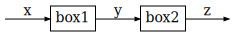

In [9]:
system = WiringDiagram([:x], [:z])

xbox = add_box!(system, Box(:box1, [:x], [:y]))
ybox = add_box!(system, Box(:box2, [:y], [:z]))

add_wires!(system, [  
  (input_id(system),1) => (xbox,1),  
  (xbox,1) => (ybox,1),
  (ybox,1) => (output_id(system),1)
])

to_graphviz(system, orientation=LeftToRight, labels=true)

In [10]:
oapply(system, [box1, box2])

┌ Warning: contract 2.0..Inf of box1 lies outside contract -Inf..5.0 of box2 at wire y
└ @ Main In[5]:41


StaticContract( [1.0,2.0] × ℝ )

__Parallel Composition:__
In this configuration, the boxes are combined to form a larger system with additional inputs and outputs. The resulting composition is:

C<sub>Parallel</sub> &rarr; C1 X C2 &rarr; (_Xin_ x _Xout_) x (_Yin_ x _Yout_) &rarr; (_Xin_ x _Yin_) x (_Xout_ x _Yout_)

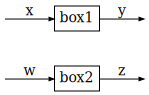

In [11]:
system = WiringDiagram([:x, :w], [:y, :z])

xbox = add_box!(system, Box(:box1, [:x], [:y]))
ybox = add_box!(system, Box(:box2, [:w], [:z]))

add_wires!(system, [  
  (input_id(system),1) => (xbox,1), 
  (input_id(system),2) => (ybox,1),
  (xbox,1) => (output_id(system),1),
  (ybox,1) => (output_id(system),2)
])

to_graphviz(system, orientation=LeftToRight, labels=true)

In [12]:
oapply(system, [box1, box2])

StaticContract( [1.0,2.0] × [-∞,5.0] × [2.0,∞] × ℝ )

### 2. Composite contract from autonomy talks

This diagram was taken from the example shown in:  [Autonomy Talks - Georgios Bakirtzis: Compositional Cyber-Physical Systems Theory](https://www.youtube.com/watch?v=Ot9szu3HZ8g)

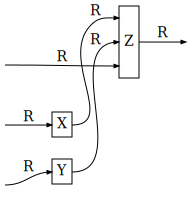

In [13]:
system = WiringDiagram([:R, :R, :R], [:R])

xbox = add_box!(system, Box(:X, [:R], [:R]))
ybox = add_box!(system, Box(:Y, [:R], [:R]))
zbox = add_box!(system, Box(:Z, [:R, :R, :R], [:R]))

add_wires!(system, [   
    (xbox,1) => (zbox,1),
    (ybox,1) => (zbox,2),
    (zbox,1) => (output_id(system),1),
    (input_id(system),2) => (xbox,1), 
    (input_id(system),3) => (ybox,1), 
    (input_id(system),1) => (zbox,3),   
])

to_graphviz(system, orientation=LeftToRight, labels=true)

In [14]:
# Contracts for each box
rx = StaticContract{Float64}( [4.0..5.0], [4.0..5.0] )
ry = StaticContract{Float64}( [8.0..9.0], [8.0..9.0] )
rz = StaticContract{Float64}( [3.0..5.0, 7.0..9.0, -Inf..Inf], [0.0..1.0] )

StaticContract( [3.0,5.0] × [7.0,9.0] × ℝ × [0.0,1.0] )

In [15]:
# Net contract for system
oapply(system, Dict(:X=>rx, :Y=>ry, :Z=>rz)) 

StaticContract( [4.0,5.0] × [8.0,9.0] × ℝ × [0.0,1.0] )

### 3. Composite contracts for UAV system

Arbitrary contracts for the UAV example in p.22 of Categorical semantics (use the link of example 1).

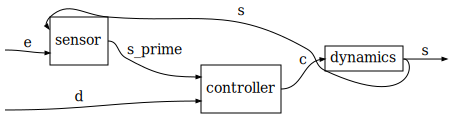

In [16]:
UAV = WiringDiagram([:e,:d], [:s])

sensor     = add_box!(UAV, Box(:sensor    , [:s, :e]      , [:s_prime]))
controller = add_box!(UAV, Box(:controller, [:s_prime, :d], [:c]))
dynamics   = add_box!(UAV, Box(:dynamics  , [:c]          , [:s]))

add_wires!(UAV, [     
  (input_id(UAV),1) => (sensor,2),
  (input_id(UAV),2) => (controller,2),
  (sensor,1) => (controller,1),
  (controller,1) => (dynamics,1),
  (dynamics,1) => (sensor,1),
  (dynamics,1) => (output_id(UAV),1)
])

to_graphviz(UAV, orientation=LeftToRight, labels=true)

In [17]:
# Define the contracts for each box
s_machine = StaticContract{Float64}([-Inf..Inf,  0.0..100.0], # Inputs -> [:s, :e]      
                                    [-Inf..Inf])              # Outputs -> [:s_prime]

c_machine = StaticContract{Float64}([-Inf..Inf,  -20.0..20.0],# Inputs -> [:s_prime, :d]
                                    [-Inf..Inf])              # Outputs -> [:c]

d_machine = StaticContract{Float64}([-Inf..Inf],     # Inputs -> [:c]
                                    [-35.0..35.0])   # Outputs -> [:s]

StaticContract( ℝ × [-35.0,35.0] )

In [18]:
# compose system
comp = oapply(UAV, Dict(:sensor => s_machine, 
                        :controller => c_machine, 
                        :dynamics => d_machine))

StaticContract( [0.0,100.0] × [-20.0,20.0] × [-35.0,35.0] )